<h1>Implementation</h1>
<h6>Collaborators: Anitha Jadhav and Nishanth M</h6>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')
# #THe above line is to load files from drive. the dataset basically. we run it.. we get the following 
# !pip install catboost hyperopt scikit-optimize

In [ ]:
import numpy as np
import pandas as pd
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss, f1_score
import matplotlib.pyplot as plt
import itertools
import catboost
import hyperopt
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
import time
import sys

In [ ]:
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

def update_tensorboard(LOG_DIR):
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6666 &'
      .format(LOG_DIR)
  )
  get_ipython().system_raw('./ngrok http 6666 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
#data = pd.read_csv("drive/My Drive/BRFSS PROJECT FILES/2017 DATA/brfss2017.csv")
data = pd.read_csv("data/brfss2017.csv")
features_selected = ["cvdinfr4","deaf","blind","x.rfhype5","x.rfchol1","x.asthms1","x.drdxar1","x.race","x.age.g","x.bmi5cat","x.chldcnt","x.educag","x.incomg","x.smoker3","x.ecigsts","x.rfdrhv5","x.totinda"]
features_7_9_nan = ["cvdinfr4","deaf","blind"]
features_9_nan = ["x.rfhype5","x.asthms1","x.race","x.chldcnt","x.educag","x.incomg","x.smoker3","x.ecigsts","x.rfdrhv5","x.totinda"]

data = data.loc[:,features_selected]
data[features_7_9_nan] = data[features_7_9_nan].replace({7:np.nan, 9:np.nan, 7.0:np.nan, 9.0:np.nan})
data[features_9_nan] = data[features_9_nan].replace({9:np.nan,9.0:np.nan})

data = data.dropna()
data["cvdinfr4"] = data["cvdinfr4"] - 1

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (171) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#####REPLACE 0,1 OF CVDINFR4
data["cvdinfr4"] = data["cvdinfr4"].replace({0:1, 1:0})

In [ ]:
X = data.loc[:,data.columns!="cvdinfr4"]
y = data.loc[:,"cvdinfr4"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=17, stratify = y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size= 0.5, random_state=17, stratify = y_test)

categorical_features_indices = np.arange(X_train.shape[1])

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validation_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)


In [ ]:
y_train.value_counts()

0.0    216641
1.0     14240
Name: cvdinfr4, dtype: int64

In [ ]:
classes = ["No", "Yes"]
def plot_confusion_matrix(cm, classes=classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Learning rate set to 0.069382
0:	learn: 0.6711819	test: 0.6709722	best: 0.6709722 (0)	total: 150ms	remaining: 12m 31s
25:	learn: 0.5407677	test: 0.5387920	best: 0.5387920 (25)	total: 3.02s	remaining: 9m 37s
50:	learn: 0.5301054	test: 0.5302012	best: 0.5302012 (50)	total: 5.73s	remaining: 9m 16s
75:	learn: 0.5266917	test: 0.5290510	best: 0.5290510 (75)	total: 8.47s	remaining: 9m 8s
100:	learn: 0.5249489	test: 0.5286747	best: 0.5286747 (100)	total: 11.1s	remaining: 8m 59s
125:	learn: 0.5233448	test: 0.5284029	best: 0.5283920 (120)	total: 13.7s	remaining: 8m 51s
150:	learn: 0.5220953	test: 0.5284833	best: 0.5283903 (126)	total: 16.4s	remaining: 8m 45s
175:	learn: 0.5204555	test: 0.5286387	best: 0.5283903 (126)	total: 19s	remaining: 8m 39s
200:	learn: 0.5189939	test: 0.5288258	best: 0.5283903 (126)	total: 21.6s	remaining: 8m 36s
225:	learn: 0.5176716	test: 0.5290224	best: 0.5283903 (126)	total: 24.3s	remaining: 8m 32s
250:	learn: 0.5164526	test: 0.5292079	best: 0.5283903 (126)	total: 26.9s

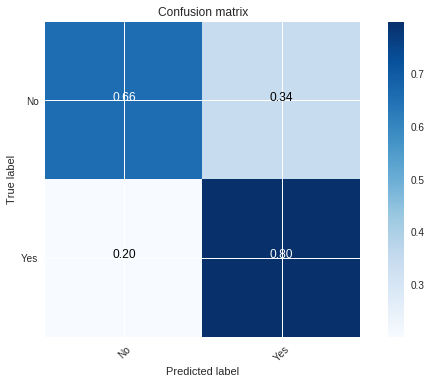

In [ ]:
model1 = CatBoostClassifier(
    random_seed=17,
    metric_period = 25,
    iterations=5000,
    task_type = "GPU",
    train_dir = "model1",
    eval_metric = "Logloss",
    custom_metric = ["AUC", "Logloss"],
    use_best_model= True,
    od_type= "Iter",
    od_wait= 300,
    scale_pos_weight = 15.23526512217449
)
model1.fit(train_pool, eval_set=validation_pool)
update_tensorboard("./model1")

y_pred = model1.predict(X_test)
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), normalize = True)
print(classification_report(y_test, y_pred, target_names=classes))

In [ ]:
update_tensorboard("model1")

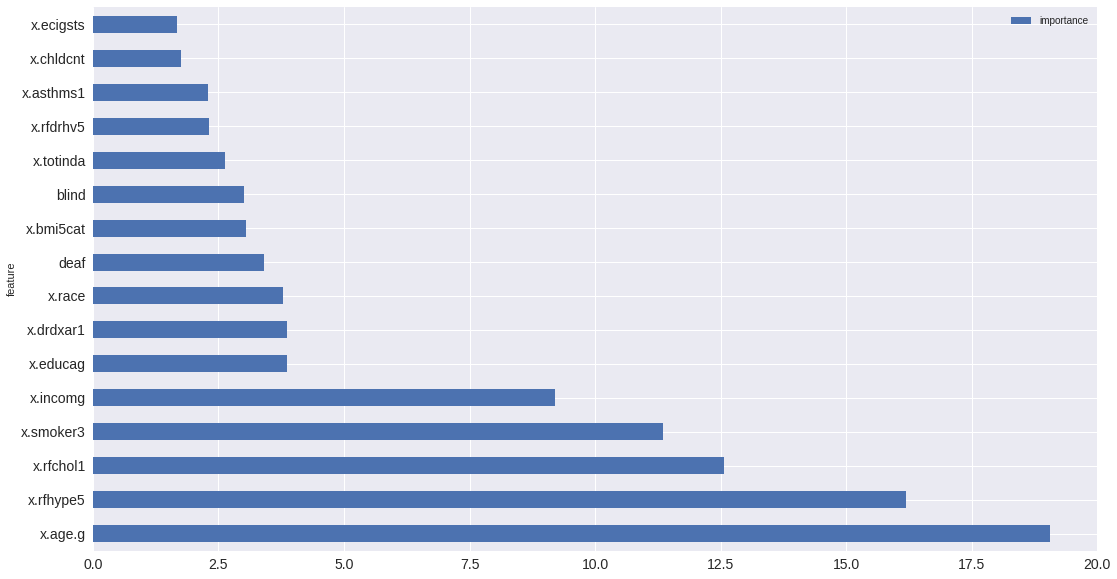

In [ ]:
feature_importance = model1.get_feature_importance(train_pool, fstr_type=catboost.EFstrType.FeatureImportance, prettified=True)
interactions = model1.get_feature_importance(train_pool, fstr_type=catboost.EFstrType.Interaction, prettified=True)
feature_importance_df = pd.DataFrame(feature_importance, columns=['feature', 'importance'])
feature_importance_df.set_index('feature').plot(kind='barh', figsize=(18, 10), fontsize=14)

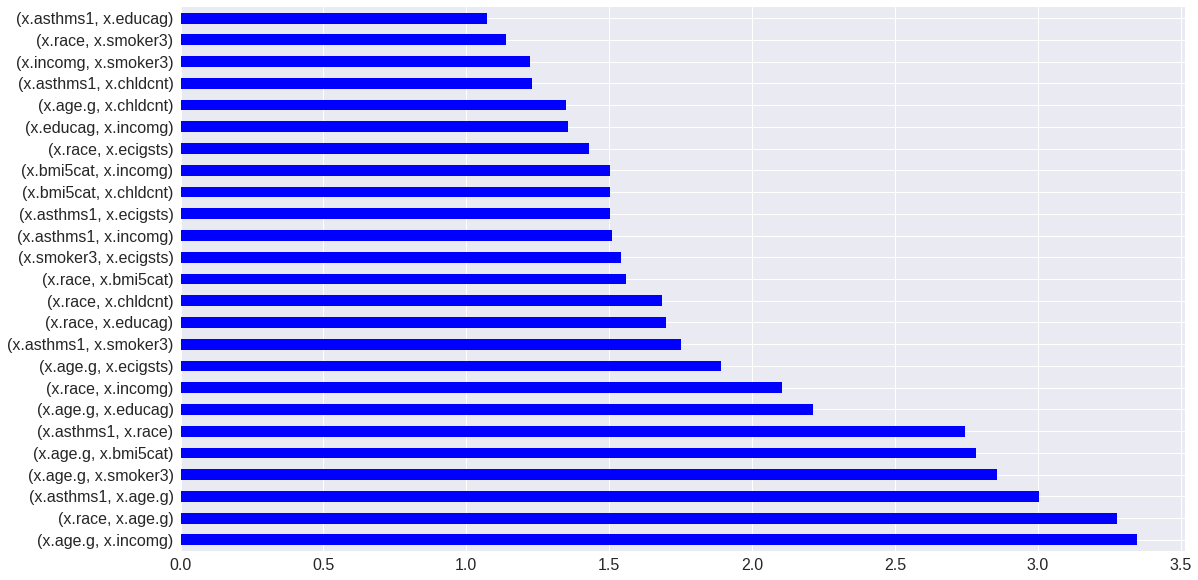

In [ ]:
feature_interaction = [[X_train.columns[interaction[0]], X_train.columns[interaction[1]], interaction[2]] for interaction in interactions]
feature_interaction_df = pd.DataFrame(feature_interaction, columns=['feature1', 'feature2', 'interaction_strength'])
pd.Series(index=zip(feature_interaction_df['feature1'], feature_interaction_df['feature2']), data=feature_interaction_df['interaction_strength'].values, name='interaction_strength').head(25).plot(kind='barh', figsize=(18, 10), fontsize=16, color='b')